<a id='index'></a>
# Comparing Toronto with the most important South American cities
## Which neighborhoods are more like Sao Paulo (Brazil), Buenos Aires (Argentina), Asuncion (Paraguay) and Montivideo (Uruguay)?

## INDEX

[Introduction](#desc1)

[Data](#desc2)

[Methodology Part 1a - Creating Toronto_Data - Scrape Wikipedia List of Toronto postal codes](#p1a)

[Methodology Part 1b - Creating Toronto_Data - Scrape Geospatial_data](#p1b)

[Methodology Part 2 - Adding the 4 South American cities to the Analysis](#p2)

[Methodology Part 3 - Combining all the data](#p3)

[Methodology Part 4 - Creating a function to connect to Foursquare API and using it](#p4)

[Methodology Part 5 - Normalizing and creating cluster using Kmeans](#p5)

[Methodology Part 6 - Analysing the clusters](#p6)

[Conclusions](#conc)

<a id='desc1'></a>

[Go back to index](#index)
## Introduction



Toronto is a very cosmopolitan city. In this city, there are several immigrants who have moved to it, either temporarily for a trip, taking a medium-term course, graduating or even permanent changes due to work or marriage.

Among the immigrants of this city, there are a considerable number of people from South America.

Migration is not always easy. South American immigrants face language, cultural, climate barriers. In this context, living in a slightly more similar place with your place of origin may be helpful.

In this context, this project aims to compare 4 major South American cities with Toronto neighborhoods and find those that are most similar to these cities.

The cities analyzed will be: 
* Sao Paulo (Brazil), 
* Buenos Aires (Argentina), 
* Asuncion (Paraguay) and 
* Montivedeu (Uruguay).

<a id='desc2'></a>
[Go back to index](#index)
## Data




The analysis of this project will include the following data:

* Foursquare API, which will provide the most common establishments from all analyzed locations (Toronto, Canada + 4 South American Cities described at introduction): https://developer.foursquare.com/


* List of Neighborhoods and Postcodes in Toronto, provided by wikipedia, that will serve as the basis of Toronto's analysis: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M


* Toronto geospatial data, Where will we have the coordinates of each neighborhood of Toronto: https://cocl.us/Geospatial_data.


* Geopy Geocoders, which will be used to convert the location of the 4 south american cities into geographic coordinates: https://pypi.org/project/geopy/


For this project, we will create a database that will contain the neighborhoods of Toronto and the 4 South American cities analyzed, with their respective commercial establishments and geographic information. This base will be used in a machine learning algorithm to create clusters (kmeans - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and as a result we will have combinations of South American cities with the neighborhoods of Toronto.

As a first step, let's capitalize Wikipedia's neighborhood data and neighborhood geospatial data, do some cleaning and treatment, and combine these two bases into one called "toronto_data".

Second step, let's create 4 databases with 4 South American cities (Sao Paulo, Buenos Aires, Asuncion, and Montivideu) with latitude and longitude using Geopy. The bases will be "saopaulo_data", "buenosaires_data", "asuncion_data" and "montivideu_data".

In the third step we will combine the above 5 bases into one. This base, which will contain a list of neighborhoods and geographic information (latitude and longitude) will be the basis for the Foursquare API.

In the fourth step we will create a function of capturing establishments based on geographic information and we will apply them to all locations.

In the fifth step the data with the establishments of each locality will be normalized and used to create cluster using Kmeans.

In the sixty step we will analyse the clusters

<a id='p1a'></a>

[Go back to index](#index)
## Methodology Part 1a - Creating Toronto Data - Scrape Wikipedia List of postal codes


### Importing libraries

In [1]:
import pandas as pd
import numpy as np

### Scrape the dataframe

We scrape a table in Wikipedia using pandas, following the instructions at https://stackoverflow.com/questions/55234512/how-to-scrap-wikipedia-tables-with-python

In [2]:
#https://stackoverflow.com/questions/55234512/how-to-scrap-wikipedia-tables-with-python
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
table = pd.read_html(url)[0]
table.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Above we have the head of the table from wikipedia. We need to remove some rows that are "Not assigned" - we will wrangle this table below.

###  Wrangling the data

In [3]:
table = table.drop(table[(table.Borough == "Not assigned")].index)

### Combining neighbourhood into one row

There is also some Borought that have more than one neighbourhood. We will combine these neighbourhoods in one row with the code below.

In [4]:
table["duplicated"]=table.duplicated(keep='first', subset="Postcode")
table['Neighborhood_2'] = np.where(table['duplicated']==True, table.Neighbourhood +', ', table.Neighbourhood)
table.drop(['Neighbourhood', 'duplicated'], axis=1, inplace=True)
table = table.groupby(['Postcode', 'Borough'], as_index=False).sum()
table.rename(columns={"Neighborhood_2": "Neighborhood"}, inplace=True)

### Neighborhood "Not assigned" to the same as the borough

In [5]:
table['Neighborhood_2'] = np.where(table['Neighborhood']=="Not assigned", table.Borough, table.Neighborhood)
table.drop(['Neighborhood'], axis=1, inplace=True)
table.rename(columns={"Neighborhood_2": "Neighborhood"}, inplace=True)

In [6]:
table.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"RougeMalvern,"
1,M1C,Scarborough,"Highland CreekRouge Hill, Port Union,"
2,M1E,Scarborough,"GuildwoodMorningside, West Hill,"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
table.shape

(103, 3)

<a id='p1b'></a>
[Go back to index](#index)
## Methodology Part 1b - Creating Toronto Data - Scrape Geospatial Data


Now we will scrable the Geospatial data at cocl. 

In [8]:
data = pd.read_csv('https://cocl.us/Geospatial_data')
data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


And we will merge the data from the wikipedia with the Geospatial data

In [9]:
table = table.merge(data, left_on='Postcode', right_on='Postal Code')
table.drop(['Postal Code'], axis=1, inplace=True)
table.head(11)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"RougeMalvern,",43.806686,-79.194353
1,M1C,Scarborough,"Highland CreekRouge Hill, Port Union,",43.784535,-79.160497
2,M1E,Scarborough,"GuildwoodMorningside, West Hill,",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount ParkIonview, Kennedy Park,",43.727929,-79.262029
7,M1L,Scarborough,"ClairleaGolden Mile, Oakridge,",43.711112,-79.284577
8,M1M,Scarborough,"CliffcrestCliffside, Scarborough Village West,",43.716316,-79.239476
9,M1N,Scarborough,"Birch CliffCliffside West,",43.692657,-79.264848


### Finishing Toronto Data

Finaly we create our Doronto data

In [10]:
toronto_data = table
toronto_data.shape
del table

<a id='p2'></a>
[Go back to index](#index)
## Methodology Part 2 - Adding the 4 South American cities to the Analysis

### Importing libraries

In [11]:
from pandas import DataFrame

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

### Adding Sao Paulo, Buenos Aires and Montivideo to the Dataframe
The geographic information (Latitude and Longitude) is taken using the Geopy Librarie

We create a simple dataframe for Sao Paulo containing only the Latitude and Longitude from Geopy.

In [12]:
address = 'Sao Paulo, Brazil'
Borough = "South America"

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sao Paulo are {}, {}.'.format(latitude, longitude))

Data = {'Borough':[Borough], 'Neighborhood': [address],
        'Latitude': [latitude], "Longitude" : [longitude]
        }
saopaulo_data = DataFrame(Data,columns= ['Borough','Neighborhood', 'Latitude', "Longitude"])

The geograpical coordinate of Sao Paulo are -23.5506507, -46.6333824.


We create a simple dataframe for Buenos Aires containing only the Latitude and Longitude from Geopy.

In [13]:
address = 'Buenos Aires, Argentina'
Borough = "South America"

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Buenos Aires are {}, {}.'.format(latitude, longitude))

Data = {'Borough':[Borough], 'Neighborhood': [address],
        'Latitude': [latitude], "Longitude" : [longitude]
        }
argentina_data = DataFrame(Data,columns= ['Borough','Neighborhood', 'Latitude', "Longitude"])

The geograpical coordinate of Buenos Aires are -34.6075616, -58.437076.


We create a simple dataframe for Asuncion containing only the Latitude and Longitude from Geopy.

In [14]:
address = 'Asuncion, paraguay'
Borough = "South America"

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of asuncion_data are {}, {}.'.format(latitude, longitude))

Data = {'Borough':[Borough], 'Neighborhood': [address],
        'Latitude': [latitude], "Longitude" : [longitude]
        }
asuncion_data = DataFrame(Data,columns= ['Borough','Neighborhood', 'Latitude', "Longitude"])

The geograpical coordinate of asuncion_data are -25.2800459, -57.6343814.


We create a simple dataframe for Montevideo containing only the Latitude and Longitude from Geopy.

In [15]:
address = 'Montevideo, Uruguay'
Borough = "South America"

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Montivideu are {}, {}.'.format(latitude, longitude))

Data = {'Borough':[Borough], 'Neighborhood': [address],
        'Latitude': [latitude], "Longitude" : [longitude]
        }
uruguay_data = DataFrame(Data,columns= ['Borough','Neighborhood', 'Latitude', "Longitude"])

The geograpical coordinate of Montivideu are -34.9059039, -56.1913569.


<a id='p3'></a>
[Go back to index](#index)
## Methodology Part 3 - Combining all the data

We combine all the tables using pandas append.

In [16]:
alldata = toronto_data.append(saopaulo_data, sort=False)
alldata = alldata.append(argentina_data, sort=False)
alldata = alldata.append(asuncion_data, sort=False)
alldata = alldata.append(uruguay_data, sort=False)
alldata.shape

(107, 5)

<a id='p4'></a>
[Go back to index](#index)
## Methodology Part 4 - Creating a function to connect to Foursquare API and using it

### Importing libraries

In [121]:
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from collections import Counter
import seaborn
import matplotlib.pyplot as plt

### Define Foursquare Credentials and Version

In [18]:
CLIENT_ID = 'CE1N3QEBYUJG4ETCLZ1QHK3C2K1DMJBAH2ZBXJPICVW5AE5Q' # your Foursquare ID
CLIENT_SECRET = 'HYA2B01YII2OQRP4OWFAEWTOUXHGM35FCQ4YOJI55Q1YVKUL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CE1N3QEBYUJG4ETCLZ1QHK3C2K1DMJBAH2ZBXJPICVW5AE5Q
CLIENT_SECRET:HYA2B01YII2OQRP4OWFAEWTOUXHGM35FCQ4YOJI55Q1YVKUL


### Taking Toronto Central Position

In [19]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


In [20]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of RougeMalvern,  are 43.806686299999996, -79.19435340000001.


In [21]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=CE1N3QEBYUJG4ETCLZ1QHK3C2K1DMJBAH2ZBXJPICVW5AE5Q&client_secret=HYA2B01YII2OQRP4OWFAEWTOUXHGM35FCQ4YOJI55Q1YVKUL&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=500&limit=100'

### get_category_type function from the Foursquare lab.

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### clean the json and structure it into a *pandas* dataframe.

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Write the code to run the above function on each neighborhood and create a new dataframe called *alldata_venues*.

In [24]:
alldata_venues = getNearbyVenues(names=alldata['Neighborhood'],
                                   latitudes=alldata['Latitude'],
                                   longitudes=alldata['Longitude']
                                  )

RougeMalvern, 
Highland CreekRouge Hill, Port Union, 
GuildwoodMorningside, West Hill, 
Woburn
Cedarbrae
Scarborough Village
East Birchmount ParkIonview, Kennedy Park, 
ClairleaGolden Mile, Oakridge, 
CliffcrestCliffside, Scarborough Village West, 
Birch CliffCliffside West, 
Dorset ParkScarborough Town Centre, Wexford Heights, 
MaryvaleWexford, 
Agincourt
Clarks CornersSullivan, Tam O'Shanter, 
Agincourt NorthL'Amoreaux East, Milliken, Steeles East, 
L'Amoreaux West
Upper Rouge
Hillcrest Village
FairviewHenry Farm, Oriole, 
Bayview Village
Silver HillsYork Mills, 
NewtonbrookWillowdale, 
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon ParkDon Mills South, 
Bathurst ManorDownsview North, Wilson Heights, 
Northwood ParkYork University, 
CFB TorontoDownsview East, 
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine GardensParkview Hill, 
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth WestRi

### Let's check the size of the resulting dataframe

In [25]:
print(alldata_venues.shape)
alldata_venues.head()

(2535, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"RougeMalvern,",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland CreekRouge Hill, Port Union,",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"GuildwoodMorningside, West Hill,",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"GuildwoodMorningside, West Hill,",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"GuildwoodMorningside, West Hill,",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [26]:
alldata_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"AdelaideKing, Richmond,",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt NorthL'Amoreaux East, Milliken, Steeles East,",2,2,2,2,2,2
"Albion GardensBeaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown,",10,10,10,10,10,10
"AlderwoodLong Branch,",8,8,8,8,8,8
"Asuncion, paraguay",90,90,90,90,90,90
"Bathurst ManorDownsview North, Wilson Heights,",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford ParkLawrence Manor East,",21,21,21,21,21,21


### Finding out how many unique categories can be curated from all the returned venues

In [27]:
print('There are {} uniques categories.'.format(len(alldata_venues['Venue Category'].unique())))

There are 292 uniques categories.


<a id='p5'></a>
[Go back to index](#index)
## Methodology Part 5 - Normalizing and creating cluster using Kmeans

In [28]:
# one hot encoding
alldata_onehot = pd.get_dummies(alldata_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
alldata_onehot['Neighborhood'] = alldata_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [alldata_onehot.columns[-1]] + list(alldata_onehot.columns[:-1])
alldata_onehot = alldata_onehot[fixed_columns]

alldata_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
alldata_onehot.shape

(2535, 292)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
alldata_grouped = alldata_onehot.groupby('Neighborhood').mean().reset_index()
alldata_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"AdelaideKing, Richmond,",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.0
1,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,"Agincourt NorthL'Amoreaux East, Milliken, Stee...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,"Albion GardensBeaumond Heights, Humbergate, Ja...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,"AlderwoodLong Branch,",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,"Asuncion, paraguay",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.0
6,"Bathurst ManorDownsview North, Wilson Heights,",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,Bayview Village,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,"Bedford ParkLawrence Manor East,",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [31]:
alldata_grouped.shape

(103, 292)

#### Let's print each neighborhood along with the top 5 most common venues

In [32]:
num_top_venues = 5

for hood in alldata_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = alldata_grouped[alldata_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AdelaideKing, Richmond, ----
            venue  freq
0     Coffee Shop  0.07
1            Café  0.05
2             Bar  0.04
3      Steakhouse  0.04
4  Breakfast Spot  0.03


----Agincourt----
                       venue  freq
0               Skating Rink  0.25
1                     Lounge  0.25
2  Latin American Restaurant  0.25
3             Breakfast Spot  0.25
4                Yoga Studio  0.00


----Agincourt NorthL'Amoreaux East, Milliken, Steeles East, ----
                       venue  freq
0                 Playground   0.5
1                       Park   0.5
2                Yoga Studio   0.0
3  Middle Eastern Restaurant   0.0
4                      Motel   0.0


----Albion GardensBeaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown, ----
                 venue  freq
0          Pizza Place   0.2
1  Japanese Restaurant   0.1
2             Pharmacy   0.1
3           Beer Store   0.1
4       Discount Store   0.1


----AlderwoodLong Br

                  venue  freq
0        Clothing Store  0.14
1  Fast Food Restaurant  0.07
2           Coffee Shop  0.07
3         Women's Store  0.04
4   Japanese Restaurant  0.04


----First Canadian PlaceUnderground city, ----
         venue  freq
0  Coffee Shop  0.12
1         Café  0.07
2        Hotel  0.04
3   Restaurant  0.04
4   Steakhouse  0.04


----Flemingdon ParkDon Mills South, ----
              venue  freq
0  Asian Restaurant  0.08
1        Beer Store  0.08
2               Gym  0.08
3       Coffee Shop  0.08
4        Restaurant  0.04


----Forest Hill NorthForest Hill West, ----
              venue  freq
0              Park  0.25
1     Jewelry Store  0.25
2             Trail  0.25
3  Sushi Restaurant  0.25
4       Yoga Studio  0.00


----Glencairn----
                 venue  freq
0  Japanese Restaurant   0.2
1     Asian Restaurant   0.2
2                 Park   0.2
3                  Pub   0.2
4     Sushi Restaurant   0.2


----GuildwoodMorningside, West Hill, ----
      

                venue  freq
0         Coffee Shop  0.06
1                Café  0.06
2               Hotel  0.05
3          Restaurant  0.05
4  Italian Restaurant  0.04


----Stn A PO Boxes 25 The Esplanade----
                venue  freq
0         Coffee Shop  0.11
1                Café  0.04
2          Restaurant  0.04
3              Bakery  0.03
4  Italian Restaurant  0.03


----Studio District----
                 venue  freq
0                 Café  0.11
1          Coffee Shop  0.08
2               Bakery  0.05
3   Italian Restaurant  0.05
4  American Restaurant  0.05


----The AnnexNorth Midtown, Yorkville, ----
            venue  freq
0  Sandwich Place  0.14
1            Café  0.14
2            Park  0.09
3     Coffee Shop  0.09
4  History Museum  0.05


----The Beaches----
                       venue  freq
0          Health Food Store  0.25
1                      Trail  0.25
2                        Pub  0.25
3                Yoga Studio  0.00
4  Middle Eastern Restaurant  0.00


### Puting that into a *pandas* dataframe

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating the new dataframe and display the top 10 venues for each neighborhood + 4 South American Cities

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = alldata_grouped['Neighborhood']

for ind in np.arange(alldata_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(alldata_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"AdelaideKing, Richmond,",Coffee Shop,Café,Steakhouse,Bar,American Restaurant,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Bakery,Breakfast Spot
1,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Empanada Restaurant,Deli / Bodega
2,"Agincourt NorthL'Amoreaux East, Milliken, Stee...",Playground,Park,Women's Store,Discount Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
3,"Albion GardensBeaumond Heights, Humbergate, Ja...",Pizza Place,Pharmacy,Beer Store,Fried Chicken Joint,Japanese Restaurant,Fast Food Restaurant,Discount Store,Sandwich Place,Grocery Store,Airport Terminal
4,"AlderwoodLong Branch,",Pizza Place,Skating Rink,Pub,Coffee Shop,Gym,Pharmacy,Sandwich Place,Dance Studio,Deli / Bodega,Department Store


### Runnig K-Means

Run *k*-means to cluster the neighborhood into 10 clusters.

In [35]:
# set number of clusters
kclusters = 10

alldata_grouped_clustering = alldata_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(alldata_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 8, 0, 0, 0, 0, 0, 0, 0])

In [36]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

alldata_merged = alldata

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
alldata_merged = alldata_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

alldata_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"RougeMalvern,",43.806686,-79.194353,7.0,Fast Food Restaurant,Women's Store,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
1,M1C,Scarborough,"Highland CreekRouge Hill, Port Union,",43.784535,-79.160497,3.0,Bar,Women's Store,Dance Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
2,M1E,Scarborough,"GuildwoodMorningside, West Hill,",43.763573,-79.188711,0.0,Electronics Store,Breakfast Spot,Intersection,Rental Car Location,Mexican Restaurant,Medical Center,Pizza Place,Donut Shop,Doner Restaurant,Drugstore
3,M1G,Scarborough,Woburn,43.770992,-79.216917,5.0,Coffee Shop,Korean Restaurant,Women's Store,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Hakka Restaurant,Caribbean Restaurant,Lounge,Bank,Bakery,Fried Chicken Joint,Thai Restaurant,Athletics & Sports,Convenience Store,Cosmetics Shop


In [39]:
alldata_merged.to_csv("teste.csv")

In [42]:
alldata_merged['Cluster Labels'] = alldata_merged['Cluster Labels'].fillna(0).astype(int)

<a id='p6'></a>
[Go back to index](#index)
## Methodology Part 6 - Analysing the clusters

### Finally, let's visualize the resulting clusters

In [43]:
# create map
map_clusters = folium.Map(location=[latitude+0.06, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(alldata_merged['Latitude'], alldata_merged['Longitude'], alldata_merged['Neighborhood'], alldata_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

I listed below all the clusters. The 1st cluster is the most important in numbers of neighbourhoods. Maybe the model will be need to be adjusted.

#### Cluster 1

In [44]:
alldata_merged.loc[alldata_merged['Cluster Labels'] == 0, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"GuildwoodMorningside, West Hill,",Electronics Store,Breakfast Spot,Intersection,Rental Car Location,Mexican Restaurant,Medical Center,Pizza Place,Donut Shop,Doner Restaurant,Drugstore
4,Cedarbrae,Hakka Restaurant,Caribbean Restaurant,Lounge,Bank,Bakery,Fried Chicken Joint,Thai Restaurant,Athletics & Sports,Convenience Store,Cosmetics Shop
5,Scarborough Village,Health & Beauty Service,Playground,Convenience Store,Women's Store,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
6,"East Birchmount ParkIonview, Kennedy Park,",Convenience Store,Department Store,Coffee Shop,Hobby Shop,Discount Store,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
7,"ClairleaGolden Mile, Oakridge,",Bakery,Bus Line,Park,Intersection,Bus Station,Fast Food Restaurant,Soccer Field,Eastern European Restaurant,Dumpling Restaurant,Drugstore
9,"Birch CliffCliffside West,",General Entertainment,College Stadium,Café,Skating Rink,Women's Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
10,"Dorset ParkScarborough Town Centre, Wexford He...",Indian Restaurant,Vietnamese Restaurant,Gaming Cafe,Chinese Restaurant,Pet Store,College Rec Center,Discount Store,Dance Studio,Deli / Bodega,Department Store
11,"MaryvaleWexford,",Middle Eastern Restaurant,Bakery,Smoke Shop,Breakfast Spot,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
12,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Empanada Restaurant,Deli / Bodega
13,"Clarks CornersSullivan, Tam O'Shanter,",Pizza Place,Bank,Italian Restaurant,Pharmacy,Fried Chicken Joint,Rental Car Location,Noodle House,Fast Food Restaurant,Chinese Restaurant,Thai Restaurant


#### Cluster 2

In [45]:
alldata_merged.loc[alldata_merged['Cluster Labels'] == 1, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,York Mills West,Park,Convenience Store,Bank,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
25,Parkwoods,Park,Food & Drink Shop,Bus Stop,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
30,"CFB TorontoDownsview East,",Park,Airport,Electronics Store,Women's Store,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
40,East Toronto,Park,Intersection,Convenience Store,Coffee Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
74,Caledonia-Fairbanks,Park,Women's Store,Fast Food Restaurant,Market,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
90,"The KingswayMontgomery Road, Old Mill North,",Park,River,Smoke Shop,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
98,Weston,Park,Convenience Store,Women's Store,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store


#### Cluster 3

In [46]:
alldata_merged.loc[alldata_merged['Cluster Labels'] == 2, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"Silver HillsYork Mills,",Cafeteria,Women's Store,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


#### Cluster 4

In [47]:
alldata_merged.loc[alldata_merged['Cluster Labels'] == 3, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Highland CreekRouge Hill, Port Union,",Bar,Women's Store,Dance Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant


#### Cluster 5

In [48]:
alldata_merged.loc[alldata_merged['Cluster Labels'] == 4, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,"Humber BayKing's Mill Park, Kingsway Park Sout...",Baseball Field,Women's Store,Dance Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
97,"EmeryHumberlea,",Furniture / Home Store,Baseball Field,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


#### Cluster 6

In [49]:
alldata_merged.loc[alldata_merged['Cluster Labels'] == 5, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Woburn,Coffee Shop,Korean Restaurant,Women's Store,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


#### Cluster 7

In [50]:
alldata_merged.loc[alldata_merged['Cluster Labels'] == 6, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Roselawn,Garden,Women's Store,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


#### Cluster 8

In [51]:
alldata_merged.loc[alldata_merged['Cluster Labels'] == 7, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"RougeMalvern,",Fast Food Restaurant,Women's Store,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant


#### Cluster 9

In [52]:
alldata_merged.loc[alldata_merged['Cluster Labels'] == 8, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Agincourt NorthL'Amoreaux East, Milliken, Stee...",Playground,Park,Women's Store,Discount Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
48,"Moore ParkSummerhill East,",Park,Tennis Court,Playground,Restaurant,Women's Store,Dim Sum Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store
50,Rosedale,Park,Playground,Trail,Women's Store,Discount Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


#### Cluster 10

In [53]:
alldata_merged.loc[alldata_merged['Cluster Labels'] == 9, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"CliffcrestCliffside, Scarborough Village West,",Movie Theater,American Restaurant,Motel,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store


### All South American cities

In [58]:
alldata_merged.loc[alldata_merged['Borough'] == "South America", alldata_merged.columns[[2] + list(range(5, alldata_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Sao Paulo, Brazil",0,Brazilian Restaurant,Bakery,Japanese Restaurant,Arts & Crafts Store,Café,Cosmetics Shop,Bookstore,Miscellaneous Shop,Vegetarian / Vegan Restaurant,Juice Bar
0,"Buenos Aires, Argentina",0,Argentinian Restaurant,Bakery,Pizza Place,Café,Fast Food Restaurant,Chinese Restaurant,Science Museum,Supermarket,Amphitheater,Dance Studio
0,"Asuncion, paraguay",0,Café,Fast Food Restaurant,Bar,Ice Cream Shop,Coffee Shop,Historic Site,Theater,Hotel,Boutique,Building
0,"Montevideo, Uruguay",0,Hotel,Theater,Bakery,Restaurant,Convenience Store,Bar,Sandwich Place,Hostel,Café,Furniture / Home Store


All South American cities are in Cluster 1, the biggest one. In this cluster are neighbourhoods like  GuildwoodMorningside, East Birchmount ParkIonview, Kennedy Park, West Hill, Clarks CornersSullivan, Tam O'Shanter.

Lets create a dataframe that lists the 1st to 5th Most common venue of this cluster

In [172]:
cluster1 = alldata_merged.loc[alldata_merged['Cluster Labels'] == 0, alldata_merged.columns[[2] + list(range(6, alldata_merged.shape[1]))]]

In [173]:
analise = cluster1["1st Most Common Venue"]
analise2 = cluster1["2nd Most Common Venue"]
analise = analise.append(analise2)
analise3 = cluster1["3rd Most Common Venue"]
analise = analise.append(analise3)
analise4 = cluster1["4th Most Common Venue"]
analise = analise.append(analise4)
analise5 = cluster1["5th Most Common Venue"]
analise = analise.append(analise5)

analise = Counter(analise)
analise = pd.DataFrame.from_dict(analise, orient='index').reset_index()
analise.columns = ["Store","Count"]
analise.sort_values(by=['Count'], ascending=False, inplace=True)
analise = analise.head(11)

Lets Plot the top 10 venues of the cluster 1, the cluster that contais the 4 south american cities.
We can see below that the most common venue are Coffe Shop by far, followed Cafés, Bakery, Parks....

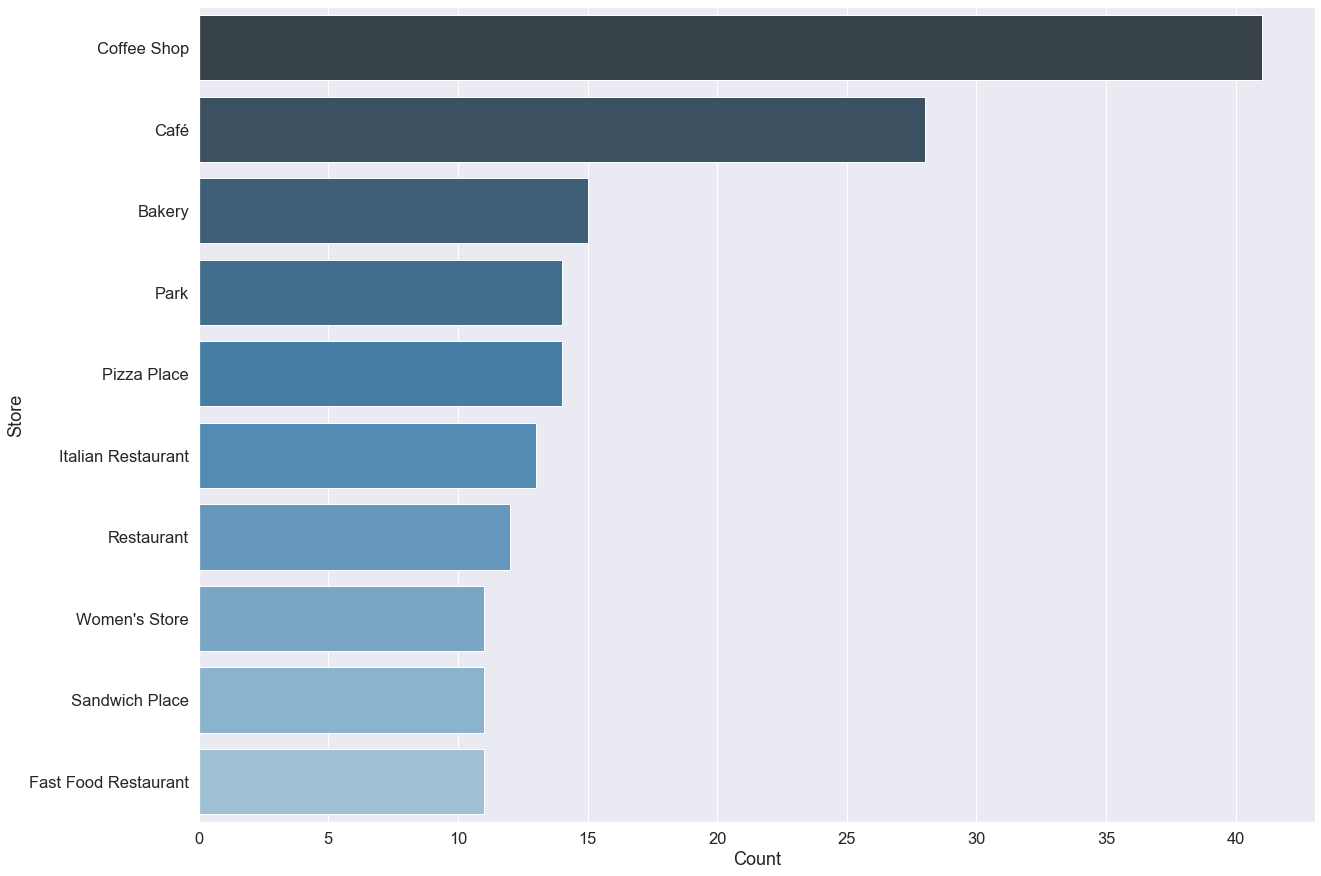

In [174]:
plt.figure(figsize=(20, 15))
seaborn.set(font_scale=1.5)
seaborn.barplot(data=analise, y="Store", x="Count", palette="Blues_d")


<a id='conc'></a>
[Go back to index](#index)
## Conclusions

In this work we take public data from neighborhoods of Toronto, Canada (list of neighborhoods and geographic information) as well as the location of 4 major Latin American cities (Sao Paulo - Brazil, Asuncion - Paraguay, Buenos Aires - Argentina and Montevideo - Uruguay).

We combined this information into one database, which contained locations and geographic information. This combined base contained 107 locations to be analyzed.

A connection has been made to the Foursquare API and a function has been created to fetch Venues for each of the locations.
Running this function in the combined database found 292 unique venus.

The combined database (with locations and venues) contains 2535 rows per 292 columns.

The database containing the neighborhood list and each venue type was normalized and used with Machine Learning.
We ran a Kmeans algorithm that clustered all neighborhoods into 10 clusters based on the venues of every 1.
Finally, we created a dataframe listing the 10 most common venus by neighborhood and added the created clusters.

Cluster distribution was highly concentrated in cluster 1, which contained 89 neighborhoods, including the 4 South American cities.
Cluster 1 is quite abundant in coffee shops and cafes and generally contains plenty of restaurants.